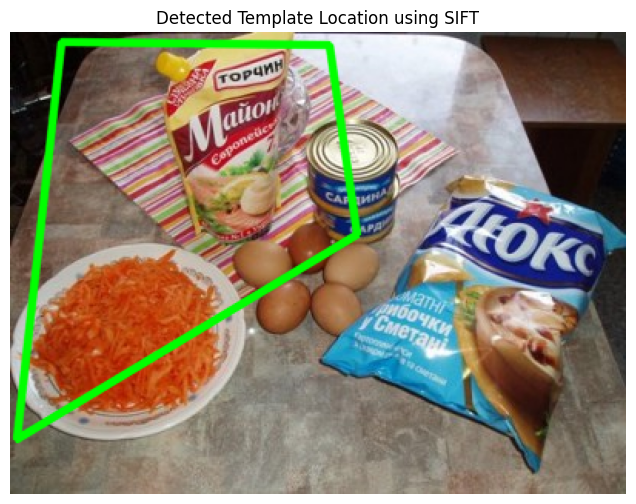

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
large_image = cv2.imread('images/Recept.jpg', cv2.IMREAD_COLOR)
small_image = cv2.imread('images/Majon.jpg', cv2.IMREAD_COLOR)

# Convert the images to grayscale
large_image_gray = cv2.cvtColor(large_image, cv2.COLOR_BGR2GRAY)
small_image_gray = cv2.cvtColor(small_image, cv2.COLOR_BGR2GRAY)

# Initialize the SIFT detector
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
keypoints_large, descriptors_large = sift.detectAndCompute(large_image_gray, None)
keypoints_small, descriptors_small = sift.detectAndCompute(small_image_gray, None)

# Use FLANN-based matcher for finding matches
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(descriptors_small, descriptors_large, k=2)

# Store good matches using Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Minimum number of matches to consider it a good detection
MIN_MATCH_COUNT = 9

if len(good_matches) > MIN_MATCH_COUNT:
    # Extract the locations of matched keypoints
    src_pts = np.float32([keypoint.pt for keypoint in keypoints_small])[np.array([m.queryIdx for m in good_matches])]
    dst_pts = np.float32([keypoint.pt for keypoint in keypoints_large])[np.array([m.trainIdx for m in good_matches])]

    # Find homography
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Get the dimensions of the small image
    h, w = small_image_gray.shape

    # Create points for the small image's corners and map them to the large image
    corners = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
    transformed_corners = cv2.perspectiveTransform(corners, H)

    # Draw a polygon on the large image to mark where the small image was found
    large_image = cv2.polylines(large_image, [np.int32(transformed_corners)], True, (0, 255, 0), 3, cv2.LINE_AA)

    # Display the results
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(large_image, cv2.COLOR_BGR2RGB))
    plt.title('Detected Template Location using SIFT')
    plt.axis('off')
    plt.show()

else:
    print("Not enough matches are found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT))

